In [1]:
import math
import cv2
import numpy as np
from pupil_apriltags import Detector
import matplotlib.pyplot as plt
import matplotlib

def track_apriltag_trajectory(video_path):
    # Initialize video capture from video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video")
        return [], [], []

    # Initialize AprilTag detector
    detector = Detector(families='tag16h5',
                       nthreads=1,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)
    
    # Arrays to store trajectory
    x_positions = []
    y_positions = []
    e_distance = []

    end_point_x = 610   
    end_point_y = 395

    last_valid_center = [834, 301]

    MAX_MOVEMENT = 30
    
    while True:
        # Read frame from video
        ret, frame = cap.read()
        if not ret or frame is None:
            print("End of video or failed to read frame")
            break
            
        # Adjust brightness
        brightness_factor = 1.0
        adjusted_frame = cv2.convertScaleAbs(frame, beta=0)

        adjusted_frame = cv2.resize(adjusted_frame, (1280, 720))
        
        # Convert adjusted frame to grayscale
        gray = cv2.cvtColor(adjusted_frame, cv2.COLOR_BGR2GRAY)
        
        # Detect AprilTags in the frame
        results = detector.detect(gray)

        valid_detections = []
        for r in results:
            # Only consider detections with high decision margin (confidence)
            if r.decision_margin > 0.999:  # Adjust this threshold as needed
                tag_id = r.tag_id
                center = tuple(int(c) for c in r.center)

                if tag_id == 0:
                    # Check if movement is physically possible
                    if last_valid_center is None or (
                        math.sqrt((center[0] - last_valid_center[0])**2 + 
                                (center[1] - last_valid_center[1])**2) < MAX_MOVEMENT):
                        valid_detections.append((tag_id, center, r.corners.astype(int)))
                        last_valid_center = center
            
        # Draw detection results and store positions
        for tag_id, center, corners in valid_detections:
            # Store positions
            x_positions.append(center[0])
            y_positions.append(center[1])
            e_distance.append(math.sqrt((center[0] - end_point_x)**2 + (center[1] - end_point_y)**2))
        
            # Draw the tag outline
            cv2.polylines(gray, [corners], True, (0, 255, 0), 2)
            
            # Draw the tag center
            cv2.circle(gray, center, 5, (0, 0, 255), -1)
            
            # Put the tag ID near the center
            cv2.putText(gray, f"ID:{tag_id}", (center[0] - 10, center[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Display the adjusted frame
        cv2.imshow('AprilTag Detection', gray)
    
    # Release everything
    cap.release()
    cv2.destroyAllWindows()

    plt.figure(figsize=(10, 10))
    plt.plot(x_positions, y_positions, 'b-', label='Tag Trajectory')
    plt.title('AprilTag Trajectory')
    plt.xlabel('X Position (pixels)')
    plt.ylabel('Y Position (pixels)')
    plt.legend()
    plt.grid(True)

    plt.show()
    
    return [], [], []
    




End of video or failed to read frame


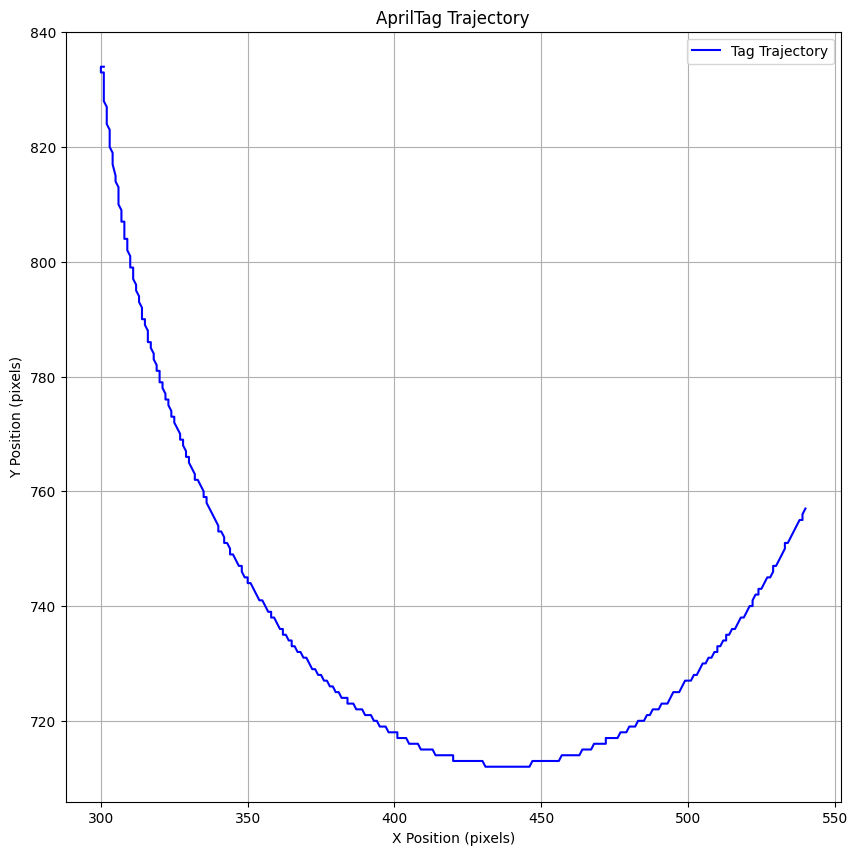

: 

In [2]:
video_path = "MotionVideos/LeftKneePitchIsolated.mp4"
x_positions, y_positions, e_distance = track_apriltag_trajectory(video_path)
